In [1]:
import os
import torch
from torch_geometric.data import HeteroData


filename = 'Job_Skill_HeteroData_v3.pt'
if os.path.exists('./'+filename):
    data = HeteroData.from_dict(torch.load('./'+filename))
    print('loading saved heterodata object')


/home/amos/mambaforge/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading saved heterodata object


In [2]:
from torch_geometric import seed_everything
import torch_geometric.transforms as T


transform = T.RandomLinkSplit(
    is_undirected=True,
    edge_types=[
        ('Job', 'REQUIRES', 'Skill'),
        ('Skill', 'IS_SIMILAR_SKILL', 'Skill'),
        ('Job', 'IS_SIMILAR_JOB', 'Job')
        ],
    rev_edge_types=[
        ('Skill', 'rev_REQUIRES', 'Job'),
        ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'),
        ('Job', 'rev_IS_SIMILAR_JOB', 'Job')
    ],
    num_val=0.005,
    num_test=0.01,
    add_negative_train_samples=False, # only adds neg samples for val and test, neg train are added by LinkNeighborLoader. This means for each train batch, negs. are different, for val and train they stay the same
    neg_sampling_ratio=1.0,
    disjoint_train_ratio=0, #  training edges are shared for message passing and supervision
    

    )

seed_everything(4)
train_data, val_data, test_data = transform(data)

In [3]:
# from torch_geometric.loader import NeighborLoader

# train_loader = NeighborLoader(
#     train_data,
#     # Sample 15 neighbors for each node and each edge type for 2 iterations:
#     num_neighbors={
#          ('Job', 'REQUIRES', 'Skill'):[1000,10], # [add x neighbors, add y neighbors for every x neighbor]
#          ('Skill', 'rev_REQUIRES', 'Job'):[10,0],
#         ('Skill', 'IS_SIMILAR_SKILL', 'Skill'):[10,10],
#         ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):[0,0],
#         ('Job', 'IS_SIMILAR_JOB', 'Job'):[0,20], # can't sample job-job in first iteration
#         ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):[0,20],
#          },
#     # num_neighbors = [10,10],
#     # Use a batch size of 128 for sampling training nodes of type "paper":
#     batch_size=200,
#     input_nodes='Job', #if not set, we consider all nodes
#     shuffle=True,
#     drop_last=True,
#     num_workers=4,
#     directed=True,  # contains only edges which are followed randomly, False: contains full node induced subgraph
# )


In [4]:
from typing import Tuple, List
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
from torch_geometric.data import HeteroData
import gc
import multiprocessing as mp


def create_loader(data:HeteroData, edge_type:Tuple[str,str,str], num_neighbors:List[int], negative_sampling_amount:int, batch_size:int, is_training:bool)->LinkNeighborLoader:

    #print('create mini-batches for', edge)

    negative_sampling = NegativeSampling(
        mode='binary',
        amount=negative_sampling_amount  # ratio, like Graphsage
        #weight=  # "Probabilities" of nodes to be sampled: Node degree follows power law distribution
        )
    num_workers = 2
    
    loader = LinkNeighborLoader(
        data,
        num_neighbors=num_neighbors,
        # {
        #     ('Job', 'REQUIRES', 'Skill'):num_neighbors,
        #     ('Skill', 'rev_REQUIRES', 'Job'):num_neighbors,
        #     ('Skill', 'IS_SIMILAR_SKILL', 'Skill'):num_neighbors, # In this example, index 0 will never be used, since neighboring edge to a job node can't be a skill-skill edge
        #     ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):num_neighbors,
        #     ('Job', 'IS_SIMILAR_JOB', 'Job'):num_neighbors,
        #     ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):num_neighbors,
        # },
        edge_label_index=(edge_type, data[edge_type].edge_label_index), # if (edge, None), None means all edges are considered
        #  =train_data[edge].edge_label,
        neg_sampling=negative_sampling, # adds negative samples
        batch_size=batch_size,
        shuffle=is_training,
        #drop_last=True,
        num_workers=num_workers,
        directed=True,  # contains only edges which are followed, False: contains full node induced subgraph
        #disjoint=True # sampled seed node creates its own, disjoint from the rest, subgraph, will add "batch vector" to loader output
        pin_memory=True, # faster data transfer to gpu
        #num_workers=2,
        #prefetch_factor=2
    )
    print(f'Using {num_workers} workers in the dataloader for edgetype {edge_type}')

    return loader


batch_size=64
num_neighbors = [5,4]

def create_iterator(data, is_training:bool):
    loaders = []
    supervision_edge_types = []
    for edge_type in [('Job', 'REQUIRES', 'Skill'),('Job', 'IS_SIMILAR_JOB', 'Job'), ('Skill', 'IS_SIMILAR_SKILL', 'Skill')]:
        # if 'rev_' in edge_type[1]:
        #     continue    
        # we dont need rev_ target edges, since they are the same
        # rev edges are only needed in the later step for the gnn traversal
        # create mini-batches for each edge type, because LinkNeighborLoader only allows one target edge type
     
        loader = create_loader(
            data=data,
            edge_type=edge_type,
            num_neighbors=num_neighbors,
            batch_size=batch_size,
            is_training=is_training,
            negative_sampling_amount=(20 if is_training else 1)
        )
        loaders.append(loader)
        supervision_edge_types.append(edge_type)
    
    
    # creates an iterator which has as many elements as the longest iterable
    # other iterables will be repeated until the longest is done
    length = 0
    index = 0
    for i, iterable in enumerate(loaders):
        l = len(iterable)
        if l>length:
            length = l
            index = i
            
 
    # for loader in loaders:
    #     minibatch = next(iter(loader))
        

    longest_loader = loaders.pop(index)
    longest_loader_edge_type = supervision_edge_types.pop(index)
    
   
    # create a list of iterators
    iterators = [iter(loader) for loader in loaders]
    
    def iterator():
        for batch in longest_loader:
            batches = [(longest_loader_edge_type,batch)]
            for i in range(len(iterators)):
                try:
                    batches.append((supervision_edge_types[i],next(iterators[i])))
                   
                except StopIteration:
                    iterators[i] = iter(loaders[i]) # will "reinit" iterator
                    batches.append((supervision_edge_types[i],next(iterators[i])))
                    
                    
            yield tuple(batches)

    return iterator, len(longest_loader)
    
    

# watch -n 1 df -h /dev/shm
gc.collect()
train_iterator, train_batch_len = create_iterator(train_data, is_training=True)
val_iterator, val_batch_len = create_iterator(val_data, is_training=False)
test_iterator, test_batch_len = create_iterator(test_data, is_training=False)

Using 2 workers in the dataloader for edgetype ('Job', 'REQUIRES', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'IS_SIMILAR_JOB', 'Job')
Using 2 workers in the dataloader for edgetype ('Skill', 'IS_SIMILAR_SKILL', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'REQUIRES', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'IS_SIMILAR_JOB', 'Job')
Using 2 workers in the dataloader for edgetype ('Skill', 'IS_SIMILAR_SKILL', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'REQUIRES', 'Skill')
Using 2 workers in the dataloader for edgetype ('Job', 'IS_SIMILAR_JOB', 'Job')
Using 2 workers in the dataloader for edgetype ('Skill', 'IS_SIMILAR_SKILL', 'Skill')


In [5]:
# helpful article
# https://medium.com/stanford-cs224w/a-tour-of-pygs-data-loaders-9f2384e48f8f

# some info

# HeteroData(
#   Job={
#     x=[9222, 128], # node features
#     n_id=[9222] # the ids of the nodes in the original train_data set
#   },
#   (Job, REQUIRES, Skill)={
#     edge_index=[2, 14498], # sampled edges
#     edge_attr=[14498, 1],  # edge attributes of sampled edges
#     edge_label=[509170], # 1 if it is a true edge, 0 if it is a false
#     edge_label_index=[2, 509170], # all edges?
#     e_id=[14498] # edge ids of edges in the original train_data set



# if batchsize is 16 for the edge and we have neg_sampling=binary, we will have
# this many jobs:
#  Job={
#     x=[64, 128],
#     n_id=[64]
#   },
# since we sample a negative and a positive edge each, and each edge has 2 Job nodes (if our target is the job nodes)

# LinkNeighborloader will sample negative edges for the target edges only, as we expect it
# so for the "neighbor"-edges we get only positive ones

Implementing GraphSage Convolution, <br> see also https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/simple_conv.html#SimpleConv,<br> as well as  https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.SimpleConv.html#torch_geometric.nn.conv.SimpleConv

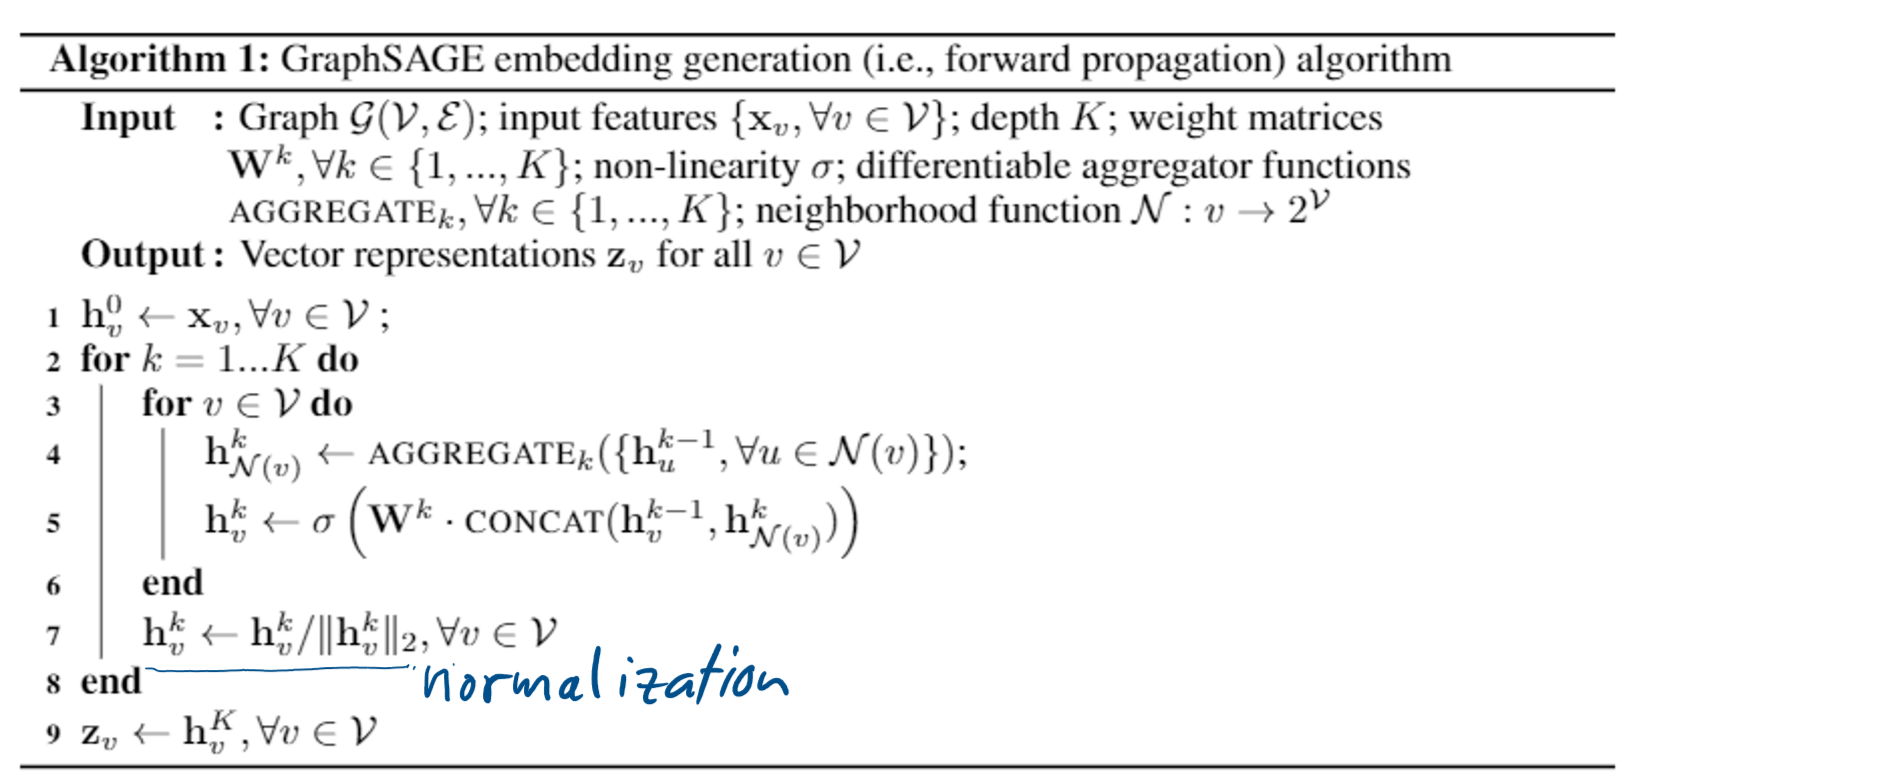

It is implemented in WeightedGraphSageConv using concatenation between h_v and h_n(v), like above.

The exact implementation is:
$$

x'_{i} =  \sigma (COMBINE(W_{i} \cdot x_{i},  W \cdot \text{AGGREGATE}\left(\left\{ h(x_{j}), \forall j \in N(j) \right\}\right))
 \quad \text(1))

$$
$$
h(x_{j}) = e_{ji} \cdot x_{i} \quad \text(2)

$$
$$
x'_{i} = \sigma (W \cdot \text{AGGREGATE}(\{x_{i}\}+\left\{ h(x_{j}), \forall j \in N(j) \right\}) \quad \text(3))
$$



Where COMBINE (1) is one of the following:
1. combine_root (str, optional) – Specifies whether or how to combine the central node representation (one of "sum", "cat"), cat will concatenate xi and the aggregation(xjs)

2. Can not be used in our case, because we have bipartite edges sometimes: self_loop as combination will consider xi like one of the xjs, see (3)

3. (2) includes the weight eji from node j to node i

AGGREGATION:
1. Mean, Max, Min, Sum, "max_pool" will do a relu(W_pool*xj) with the same weight before pooling

Notes: 
- if out_channels is 32 and COMBINE=Concatenation, then the 32 out channels will be split between xi (16) and agg(xjs) (16)

In [6]:
# see SAGE here:
from models.WeightedSkillSAGE import WeightedSkillSAGE, weightedSkillSAGE_lr_2emin7_1lin_1lin_256dim_edgeweight_checkpoints

In [7]:
from models.WeightedSkillGAT import weightedSkillGAT_lr_2emin7_256dim_4heads_2layers_edgeweights_checkpoints
model = weightedSkillGAT_lr_2emin7_256dim_4heads_2layers_edgeweights_checkpoints()

In [8]:
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAUPRC, BinaryAUROC
from tqdm.auto import tqdm
import gc
from torch.utils.tensorboard import SummaryWriter
import os
from pathlib import Path
from datetime import datetime
import torch
import numpy as np
from sklearn.metrics import f1_score


class GNNTrainer():
    def __init__(self, model, criterion, optimizer, device, log_folder):
        #super().__init__(model, criterion, optimizer, device, ) # metrics=['f1','accuracy','precision','recall', 'aucpr']
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_batch_size = 0  # for tqdm, for logging
        self.train_n_mini_in_batch = 0  # for tqdm
        self.val_n_mini_in_batch = 0  # for tqdm
        self.log_folder = log_folder
    
    def free_memory(self):
        """Clears the GPU cache and triggers garbage collection, to reduce OOMs."""
        torch.cuda.empty_cache()
        gc.collect()
        
    
            
    
        
    def write_calc_metrics(self, split_name:str, y_hat, y, y_per_edgetype, y_hat_per_edgetype, epoch:int, is_epoch:bool, minibatch:int=0, loss:int=0, loss_per_edgetype=None, print_=True):
        assert epoch>=1, 'Epoch must be >= 1'
        assert minibatch >= 1, "minibatch must be >=1"
        
        if split_name=='train':
            assert self.train_batch_size != 0
            assert self.train_n_mini_in_batch != 0
            assert loss != 0, "loss can't be 0"
            if is_epoch:
                loss_per_edge_type = {}
                y_per_edgetype = {}
                y_hat_per_edgetype = {}
            assert loss_per_edgetype is not None
            
        else:
            assert loss_per_edgetype is None
            
        if is_epoch:
            split_name = 'epoch_'+split_name
            index = epoch
        else:
            split_name = 'samples_'+split_name
            no_minibatches = (epoch-1)*self.train_n_mini_in_batch + minibatch
            approx_no_samples = no_minibatches*self.train_batch_size
            index = approx_no_samples
        
        y_per_edgetype[('','all','')]= y
        y_hat_per_edgetype[('','all','')]= y_hat
        if 'train' in split_name:
            loss_per_edgetype[('','all','')] = loss
        
        
        for edgetype in y_per_edgetype.keys():
            y = y_per_edgetype[edgetype].to(torch.int).detach().cpu()
            y_hat = y_hat_per_edgetype[edgetype].detach().cpu()
            edge_name = '-'.join(list(edgetype)).strip('-')
        
            
            def calculate_f1(y_hat, y, thresholds):
                
                return np.array([f1_score(y_hat>threshold, y, average='binary') for threshold in thresholds])
            
            # get best f1 threshold
            thresholds = np.arange(0.001, 1, 0.001)
            a, b = y_hat.numpy(), y.numpy()
            f1s = calculate_f1(a,b , thresholds)
            optimal_threshold = thresholds[np.argmax(f1s)]
            f1=max(f1s)
    
            acc, prec, rec = BinaryAccuracy(threshold=optimal_threshold).update(y_hat, y).compute().item(), BinaryPrecision(threshold=optimal_threshold).update(y_hat, y).compute().item(), BinaryRecall(threshold=optimal_threshold).update(y_hat, y).compute().item()
            self.writer.add_scalar(f'{split_name}_f1threshold_{edge_name}', optimal_threshold, index)
            self.writer.add_scalar(f'{split_name}_accuracy_{edge_name}', acc, index)
            self.writer.add_scalar(f'{split_name}_precision_{edge_name}', prec, index)
            self.writer.add_scalar(f'{split_name}_recall_{edge_name}', rec, index)
            self.writer.add_scalar(f'{split_name}_f1_{edge_name}', f1, index)
            
        
            auprc = BinaryAUPRC().update(y_hat, y).compute().item()
            auroc = BinaryAUROC().update(y_hat, y).compute().item()
            
            self.writer.add_scalar(f'{split_name}_auprc_{edge_name}', auprc, index)
            self.writer.add_scalar(f'{split_name}_auroc_{edge_name}', auroc, index)
            if 'train' in split_name:
                loss = loss_per_edgetype[edgetype]
                self.writer.add_scalar(f'{split_name}_loss_{edge_name}', loss, index)
            self.writer.flush()
            
            if print_ and edgetype==('','all',''):
                out_of = f'/{self.train_n_mini_in_batch:06d}' if 'train' in split_name else ''
                no_samples = f'|samples:{index}' if 'train' in split_name else ''
                loss_to_show = f'loss:{loss:.4f},' if 'train' in split_name else ''
                print(f'{split_name}|{int(minibatch):04d}{out_of}|{epoch:04d}{no_samples}|{loss_to_show} F1: {f1:.6f}, AUC-PR: {auprc:.6f}, (auroc: {auroc:.6f}, acc: {acc:.6f}, prec: {prec:.6f}, rec: {rec:.6f})')

    def create_logfolders(self, run_folder=None):
        if run_folder is None:
            run_folder = datetime.now().strftime('run_%d%m%Y_%H%M%S')
            
        self.writer = SummaryWriter(log_dir=Path(self.log_folder)/(run_folder+'_tensorboard'))
        self.checkpoint_folder = Path(self.log_folder)/(run_folder+'_checkpoints')
        if not os.path.exists(self.checkpoint_folder):
            os.makedirs(self.checkpoint_folder)
        
        if not os.path.exists(Path(self.log_folder)/(run_folder+'_tensorboard')):
            os.makedirs(Path(self.log_folder)/(run_folder+'_tensorboard'))
            
        print(f'run folder is {run_folder}')
        
    
    def train(self, train_iterator, val_iterator, start_epoch, n_epochs, run_folder=None, save_metrics_after_n_batches=100):
        self.free_memory()
        self.create_logfolders(run_folder)

        self.model.train()
        assert start_epoch >= 1, "Epoch must be >= 1"
        
        for epoch in range(start_epoch, start_epoch+n_epochs):
            
            epoch_loss = 0
            for batch_idx, edge_batches in tqdm(enumerate(train_iterator()), total=self.train_n_mini_in_batch, desc='train epoch'):
                batch_idx+=1  # start from 1
                self.optimizer.zero_grad()  # empty gradients
                minibatch_loss = 0
                loss_per_edgetype = {}
                y_hat, y = [], []
                y_hat_per_edgetype, y_per_edgetype = {}, {}
                for supervision_edge_type, batch in edge_batches:  # each "batch" here is one edge type, since we want to learn for all edge types
                    batch = batch.to(self.device)
                    hetero_out = model(batch.x_dict, batch.edge_index_dict, batch.edge_weight_dict, batch.num_sampled_edges_dict, batch.num_sampled_nodes_dict)  # get model output

                    # evaluate, calculate cosine sim and compute cross-entropy loss
                    src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
                    edge_label = batch[supervision_edge_type].edge_label
                    edge_label_index = batch[supervision_edge_type].edge_label_index
                    src_node_embeddings = hetero_out[src_type][edge_label_index[0]]
                    dst_node_embeddings = hetero_out[dst_type][edge_label_index[1]]
                    
                    loss, y_pred = self.criterion(src_node_embeddings, dst_node_embeddings, edge_label)
                    
                    minibatch_loss += loss
                    # collect data for metrics
                    loss_per_edgetype[supervision_edge_type] = loss.detach().item()
                    y_hat_per_edgetype[supervision_edge_type] = y_pred.detach().cpu()
                    y_per_edgetype[supervision_edge_type] = edge_label.to(torch.int).detach().cpu()
                    y_hat.append(y_hat_per_edgetype[supervision_edge_type])
                    y.append(y_per_edgetype[supervision_edge_type])
                    
                minibatch_loss.backward()
                self.optimizer.step()
                minibatch_loss = minibatch_loss.detach().item()
                epoch_loss += minibatch_loss
             
                y_hat = torch.cat(y_hat)
                y = torch.cat(y)
                # create metrics and write to tensorboard writer
                if batch_idx%save_metrics_after_n_batches==1:
                    self.write_calc_metrics('train', y_hat, y, y_per_edgetype, y_hat_per_edgetype,  epoch=epoch, minibatch=batch_idx, loss=minibatch_loss, loss_per_edgetype=loss_per_edgetype, is_epoch=False, print_=False)
                    self.validate(val_iterator, epoch, batch_idx, is_epoch=False)
                    self.model.train()  # back to training, just in case
           
            self.save_checkpoint(epoch, batch_idx)
            self.write_calc_metrics('train', y_hat, y, y_per_edgetype={}, y_hat_per_edgetype={}, loss_per_edgetype={}, epoch=epoch, minibatch=batch_idx, loss=epoch_loss, is_epoch=True, print_=True)
            self.validate(val_iterator, epoch, batch_idx, is_epoch=True)
            self.model.train()  # back to training, just in case
            
    def validate(self, val_iterator, epoch, batch_idx, is_epoch):
        self.model.eval()
        with torch.no_grad():
            y_hat, y = [], []
            y_hat_per_edgetype, y_per_edgetype = {}, {}
            for edge_batches in val_iterator():
                for supervision_edge_type, batch in edge_batches:  # each "batch" here is one edge type, since we want to learn for all edge types
                    batch = batch.to(self.device)
                    hetero_out = model(batch.x_dict, batch.edge_index_dict, batch.edge_weight_dict, batch.num_sampled_edges_dict, batch.num_sampled_nodes_dict)

                    # evaluate, calculate cosine sim and compute cross-entropy loss
                    src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
                    edge_label = batch[supervision_edge_type].edge_label
                    edge_label_index = batch[supervision_edge_type].edge_label_index
                    if src_type not in  hetero_out.keys() or dst_type not in hetero_out.keys():
                        print('eval failed on one minibatch part, skipping')
                        print('Supervision edge type:',supervision_edge_type)
                        print('one type is missing in model output',src_type, dst_type)
                        print(batch.x_dict)
                        print(hetero_out.keys())
                        print(batch)
                        continue
                        
                    src_node_embeddings = hetero_out[src_type][edge_label_index[0]]
                    dst_node_embeddings = hetero_out[dst_type][edge_label_index[1]]
                    
                    #logits = F.cosine_similarity(src_node_embeddings, dst_node_embeddings, dim=-1)
                    
                    _, y_pred = self.criterion(src_node_embeddings, dst_node_embeddings, edge_label)
                    # y_hat.append(y_pred.detach())
                    # y.append(edge_label.to(torch.int).detach())

                    # collect data for metrics
                    if supervision_edge_type not in y_hat_per_edgetype.keys():
                        y_hat_per_edgetype[supervision_edge_type] = []
                        y_per_edgetype[supervision_edge_type] = []
                        
                    y_hat_per_edgetype[supervision_edge_type].append(y_pred.detach().cpu())
                    y_per_edgetype[supervision_edge_type].append(edge_label.to(torch.int).detach().cpu())
                   
                    
            # save metrics
            for key in y_hat_per_edgetype:
                y_hat_per_edgetype[key] = torch.cat(y_hat_per_edgetype[supervision_edge_type])
                y_per_edgetype[key] = torch.cat(y_per_edgetype[supervision_edge_type])
                y_hat.append(y_hat_per_edgetype[key])
                y.append(y_per_edgetype[key])
                
            y_hat = torch.cat(y_hat)
            y = torch.cat(y)
            self.write_calc_metrics('val', y_hat, y, y_per_edgetype, y_hat_per_edgetype, epoch=epoch, is_epoch=is_epoch, print_=True, minibatch=batch_idx)
    
    def save_checkpoint(self, epoch, batch_idx):
        print(f'save checkpoint {self.checkpoint_folder}/checkpoint_ep{epoch}_{batch_idx}.pt')
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
           # 'metrics_history': self.story,
        }, f'{self.checkpoint_folder}/checkpoint_ep{epoch}.pt')

    def load_checkpoint(self, load_path):
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [10]:
import os
import torch
#os.environ["TOKENIZERS_PARALLELISM"] = "true"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
torch._dynamo.config.verbose=True
torch._dynamo.config.suppress_errors = True

optimizer = torch.optim.Adam(model.parameters(), lr=2e-7) #2e-15
def graphSAGE_loss(u, v, y_label):
    y_neg = (y_label-1)
    y_label = (y_neg + y_label).squeeze()  # has -1 for neg and 1 for pos
    # loss= -1* log(sig(u,v_pos)) - Q*E*log(sig(-1*u,v_neg)) where Q is number of neg, E is expected value
    logits = torch.sum(torch.mul(u, v), dim=-1)
    
    mul = torch.sigmoid(torch.mul(logits, y_label))
    loss = -1*torch.sum(torch.log(mul)) # sum across all examples
    y_hat = torch.sigmoid(logits) # just for metrics in later step
    return loss, y_hat.detach()

criterion = graphSAGE_loss
#criterion = torch.nn.CrossEntropyLoss()
trainer = GNNTrainer(model, criterion, optimizer, device , log_folder='runs')
#trainer.load_checkpoint('./checkpoints/checkpoint_0_300.pt')


# for tqdm
trainer.train_batch_size = batch_size
trainer.train_n_mini_in_batch = train_batch_len
trainer.val_n_mini_in_batch = val_batch_len

trainer.train(
    train_iterator, 
    val_iterator, 
    start_epoch=1, 
    n_epochs=200, 
    run_folder=f'weightedSkillGAT_lr_2emin7_256dim_4heads_2layers_edgeweights_checkpoints', # WeightedSkillSAGE_lr_2emin7_1lin_1lin_256dim_edgeweight
    save_metrics_after_n_batches=1000) # graphconv_v0_lr_2emin6_2lin_1lin_256dim
# trainer.validate(val_dataloader)
# trainer.plot_losses()
# trainer.load_checkpoint('./checkpoints/checkpoint_100.pt')
# trainer.validate(val_iterator,1)



run folder is weightedSkillGAT_lr_2emin7_256dim_4heads_2layers_edgeweights_checkpoints


train epoch:   0%|          | 0/16003 [01:25<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#tensorboard --logdir=runs
#http://localhost:6006 

9803.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.14.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
# 1440057
# 1407132.

In [ ]:
490586.58532714844
485814.1606140137
474801.0126953125

In [ ]:
# ep100, Loss: 757468.5991210938
# Loss: 739222.503692627
# oss: 737091.7985534668
#Loss: 734385.8401489258
# 732283.552154541

In [ ]:
supervision_edge_type = get_supervision_edge_type(batch)
src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
edge_label = batch[supervision_edge_type].edge_label
edge_label_index = batch[supervision_edge_type].edge_label_index
src_node_embeddings = out[src_type][edge_label_index[0]]
dst_node_embeddings = out[dst_type][edge_label_index[1]]
torch.min(F.cosine_similarity(src_node_embeddings, dst_node_embeddings, dim=-1))

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
batch[supervision_edge_type].edge_label_index

In [ ]:
J2S = ('Job','REQUIRES','Skill')
batch[J2S].edge_label_index

In [ ]:
batch['Job','REQUIRES','Skill'].

In [ ]:
batch = next(iter(train_loaders[0]))


In [ ]:
batch

In [ ]:
batch.edge_weight_dict

In [ ]:
index = batch['Job','IS_SIMILAR_JOB','Job'].e_id
labels = batch['Job','IS_SIMILAR_JOB','Job'].edge_label

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(-1, hidden_channels)
        self.conv2 = SAGEConv(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64, out_channels=dataset.num_classes)
model = to_hetero(model, data.metadata(), aggr='sum')

In [ ]:
#https://colab.research.google.com/drive/1GrAxHyZCZ13jpTkMy9vVO_v_U9nHDdvB#scrollTo=wmiFKI0ovYN4


In [ ]:
# intially we use this GraphConv layer and aggregate using mean
# this layer allows the addition of edge weights: the adjacency matrix simply consists not of 1s and 0s but the corresponding weights
#https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GraphConv.html

# using max pool
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_max_pool.html#torch_geometric.nn.pool.global_max_pool